In [96]:
import pandas as pd
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import humanize
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import editdistance
from tqdm import tqdm

In [97]:
method_palette = { "LoFreq": "#9593D9",
                   "ShoRAH": "#ffe66d",
                   "CliqueSNV":  "#4ecdc4",
                   "VILOCA": "#ff6b6b",
                   "PredictHaplo": "#227c9d",
                   "ground_truth": "grey",
                  "ground truth": "grey",
                  'HaploDMF': "#ffa96c", 
                  'Haploflow': "#95bf8f", 
                  }

mapping_methods = {
    'cliquesnv_local_haplo_snv_tf0.01': "CliqueSNV",
    'cliquesnv_local_haplo_snv': "CliqueSNV",
    'cliquesnv_local_haplo_tf0.01': "CliqueSNV",
    'cliquesnv_local_haplo_tf0.1':"CliqueSNV",
    'cliquesnv_local_haplo': "CliqueSNV",
    'shorah_default': 'ShoRAH',
    'lofreq_local_haplo': 'LoFreq',
    'viloca_alpha_0.00001': 'VILOCA',
    'viloca_alpha_0.00001_K100': 'VILOCA',
    'viloca_multi': 'VILOCA',
    'ground_truth': "ground truth",
    'predicthaplo_local_haplo': 'PredictHaplo', 
    'haplodmf': 'HaploDMF', 
    'haploflow': 'Haploflow'}

In [98]:
mapping_haplos = {
    '2@3@30@20@20@geom@0.75': 'Population 1', 
    '5@5@30@10@15@geom@0.75': 'Population 2',
    '5@10@30@10@10@geom@0.75': 'Population 3', 
    '5@15@30@10@15@geom@0.75': 'Population 4', 
    '10@5@5@4@3@geom@0.75': 'Population 5',
    
    '2@3@600@400@400@geom@0.75': 'Population 6',
    '2@3@600@600@600@geom@0.75': 'Population 7',
    '5@5@600@200@300@geom@0.75': 'Population 8', 
    '5@10@600@200@240@geom@0.75': 'Population 9',
    '5@5@100@5@5@geom@0.75': 'Population 10',
}

In [99]:
# Illumina samples
fname_pred = 'distance/performance_measures/global_illumina/csv_files/predictions.csv.gz'
df_pred = pd.read_csv(fname_pred)
df_pred = df_pred[df_pred['params'].str.startswith("seq_tech~illumina")]

fname_true = 'distance/performance_measures/global_illumina/csv_files/ground_truth.csv.gz'
df_true = pd.read_csv(fname_true)
df_true = df_true[df_true['params'].str.startswith("seq_tech~illumina")]

# long read samples
fname_pred = 'distance/performance_measures/global/csv_files/predictions.csv.gz'
df_pred_t = pd.read_csv(fname_pred)
df_pred_t = df_pred_t[~df_pred_t['params'].str.startswith("seq_tech~illumina")]

fname_true = 'distance/performance_measures/global/csv_files/ground_truth.csv.gz'
df_true_t = pd.read_csv(fname_true)
df_true_t = df_true_t[~df_true_t['params'].str.startswith("seq_tech~illumina")]

df_pred = pd.concat([df_pred, df_pred_t])
df_true = pd.concat([df_true, df_true_t])

In [100]:
df_pred['method'].unique()

array(['haplodmf', 'haploflow', 'cliquesnv_local_haplo_tf0.01',
       'viloca_alpha_0.00001', 'predicthaplo_local_haplo'], dtype=object)

In [101]:
df_pred.loc[:,'coverage'] = df_pred['params'].str.split('~').str[6].str.split('__').str[0]
df_pred = df_pred[df_pred['coverage']=='1000']
df_pred.loc[:, 'haplos'] = df_pred['params'].str.split('~').str[7].str.split('__').str[0]
df_pred.loc[:, 'seq_tech'] = df_pred['params'].str.split('~').str[1].str.split('__').str[0]

df_pred = df_pred[df_pred['method'].isin(mapping_methods.keys())]
df_pred["Method"] = df_pred['method'].apply(lambda x: mapping_methods[x])
df_pred["Population"] = df_pred['haplos'].apply(lambda x: mapping_haplos[x])
df_pred = df_pred[df_pred['Population'].isin(['Population 1', 'Population 2','Population 3','Population 4',
                              'Population 5','Population 6','Population 7','Population 8',
                              'Population 9','Population 10',])]

In [102]:
df_pred['seq_tech'].unique()

array(['illumina', 'nanopore', 'pacbio'], dtype=object)

In [103]:
df_pred = df_pred[~((df_pred['method']=="viloca_alpha_0.00001")
                        &(df_pred['posterior']<0.5)
                        &(df_pred['seq_tech']=="nanopore"))]

df_pred = df_pred[~((df_pred['method']=="viloca_alpha_0.00001")
                        &(df_pred['posterior']<0.5)
                        &(df_pred['seq_tech']=="pacbio"))]

df_pred = df_pred[~((df_pred['method']=="viloca_alpha_0.00001")
                        &(df_pred['posterior']<0.9)
                        &(df_pred['seq_tech']=="illumina"))]

In [104]:
df_pred = df_pred[~((df_pred['method']=="haploflow")
                        &(df_pred['seq_tech']=="nanopore"))]
df_pred = df_pred[~((df_pred['method']=="haploflow")
                        &(df_pred['seq_tech']=="pacbio"))]

df_pred = df_pred[~((df_pred['method']=="haplodmf")
                        &(df_pred['seq_tech']=="illumina"))]
df_pred = df_pred[~((df_pred['method']=="predicthaplo")
                        &(df_pred['seq_tech']=="illumina"))]


In [106]:
def relative_edit_distance(seq1, seq2):
    dist = editdistance.eval(seq1, seq2)
    rel = dist / max(len(seq1), len(seq2))
    return rel


def pr_worker(index, df_group, df_true, thres):
    (method, params, replicate) = index

    tp = 0
    fp = 0
    fn = 0

    df_true_grpd = df_true[
        (df_true["params"] == params) & (df_true["replicate"] == replicate)
    ]

    # subsample large results
    max_num = 500
    df_group = df_group.sample(n=min(df_group.shape[0], max_num))

    # true positive: predicted seq appears in ground truth
    # false positive: predicted seq does not appear in ground truth
    df_cur = df_true_grpd.copy()
    for row in tqdm(df_group.itertuples(), total=df_group.shape[0], leave=False):
        ser_dist = df_cur["sequence"].apply(
            lambda x: relative_edit_distance(x, row.sequence)
        )
        passed_thres = (ser_dist <= thres).any()

        if passed_thres:
            tp += 1

            # remove ground truth because it was predicted
            df_cur = df_cur.drop(ser_dist.idxmin())
        else:
            fp += 1

    # false negative: ground truth sequence was not predicted
    # single prediction should not map to multiple ground truth seqs
    df_cur = df_group.copy()
    for row in tqdm(
        df_true_grpd.itertuples(), total=df_true_grpd.shape[0], leave=False
    ):
        ser_dist = df_cur["sequence"].apply(
            lambda x: relative_edit_distance(x, row.sequence)
        )
        passed_thres = (ser_dist <= thres).any()

        if not passed_thres:
            fn += 1
        else:
            # remove current prediction
            df_cur = df_cur.drop(ser_dist.idxmin())
    
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    # finalize
    return {
        "method": method,
        "params": params,
        "replicate": replicate,
        "tp": tp,
        "fp": fp,
        "fn": fn,
        "precision": tp / (tp + fp),
        "recall": tp / (tp + fn),
        "f1": 0 if precision + recall == 0 else 2 * (precision * recall) / (precision + recall), 
    }

In [107]:
distance_thresholds = [0.0, 0.001, 0.005, 0.01, 0.05]


# Goal dataframe with the following columns
# params, method, replicate, posterior_threshold, precison, recall, f1

tmp = []

for distance_threshold in distance_thresholds:
    df_pred_tmp = df_pred
    for index, df_group in df_pred_tmp.groupby(["method", "params", "replicate"]):

        pr_list = pr_worker(index, df_group, df_true, distance_threshold)
        pr_list['distance_threshold'] = distance_threshold
        tmp.append(pr_list)
                                                   
df_pr = pd.DataFrame(tmp) 

In [108]:
df_pr_precision = df_pr[['precision', 'method', 'replicate', 'params', 'distance_threshold']]
df_pr_precision['value']= df_pr_precision['precision']
df_pr_precision['variable']='precision'
df_pr_precision = df_pr_precision[['variable','value', 'method', 'replicate', 'params', 'distance_threshold']]


df_pr_recall = df_pr[['recall', 'method', 'replicate', 'params', 'distance_threshold']]
df_pr_recall['value']= df_pr_recall['recall']
df_pr_recall['variable']='recall'
df_pr_recall = df_pr_recall[['variable','value', 'method', 'replicate', 'params', 'distance_threshold']]

df_pr_f1 = df_pr[['f1', 'method', 'replicate', 'params', 'distance_threshold']]
df_pr_f1['value']= df_pr_f1['f1']
df_pr_f1['variable']='f1'
df_pr_f1 = df_pr_f1[['variable','value', 'method', 'replicate', 'params', 'distance_threshold']]


df_pr_long = pd.concat([df_pr_recall, df_pr_precision, df_pr_f1])

df_pr_long["Method"] = df_pr_long['method'].apply(lambda x: mapping_methods[x])
df_pr_long.loc[:, 'seq_tech'] = df_pr_long['params'].str.split('~').str[1].str.split('__').str[0]


/var/folders/dw/8dl4p6h53cgcmk6cf_09v5f40000gr/T/ipykernel_94102/234424451.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pr_precision['value']= df_pr_precision['precision']
/var/folders/dw/8dl4p6h53cgcmk6cf_09v5f40000gr/T/ipykernel_94102/234424451.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pr_precision['variable']='precision'
/var/folders/dw/8dl4p6h53cgcmk6cf_09v5f40000gr/T/ipykernel_94102/234424451.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [121]:
map_seq = {'illumina': 'Illumina', 'nanopore': 'ONT', 'pacbio': 'PacBio'}

df_pr_long['seq_tech'] = df_pr_long['seq_tech'].apply(lambda x: map_seq[x])

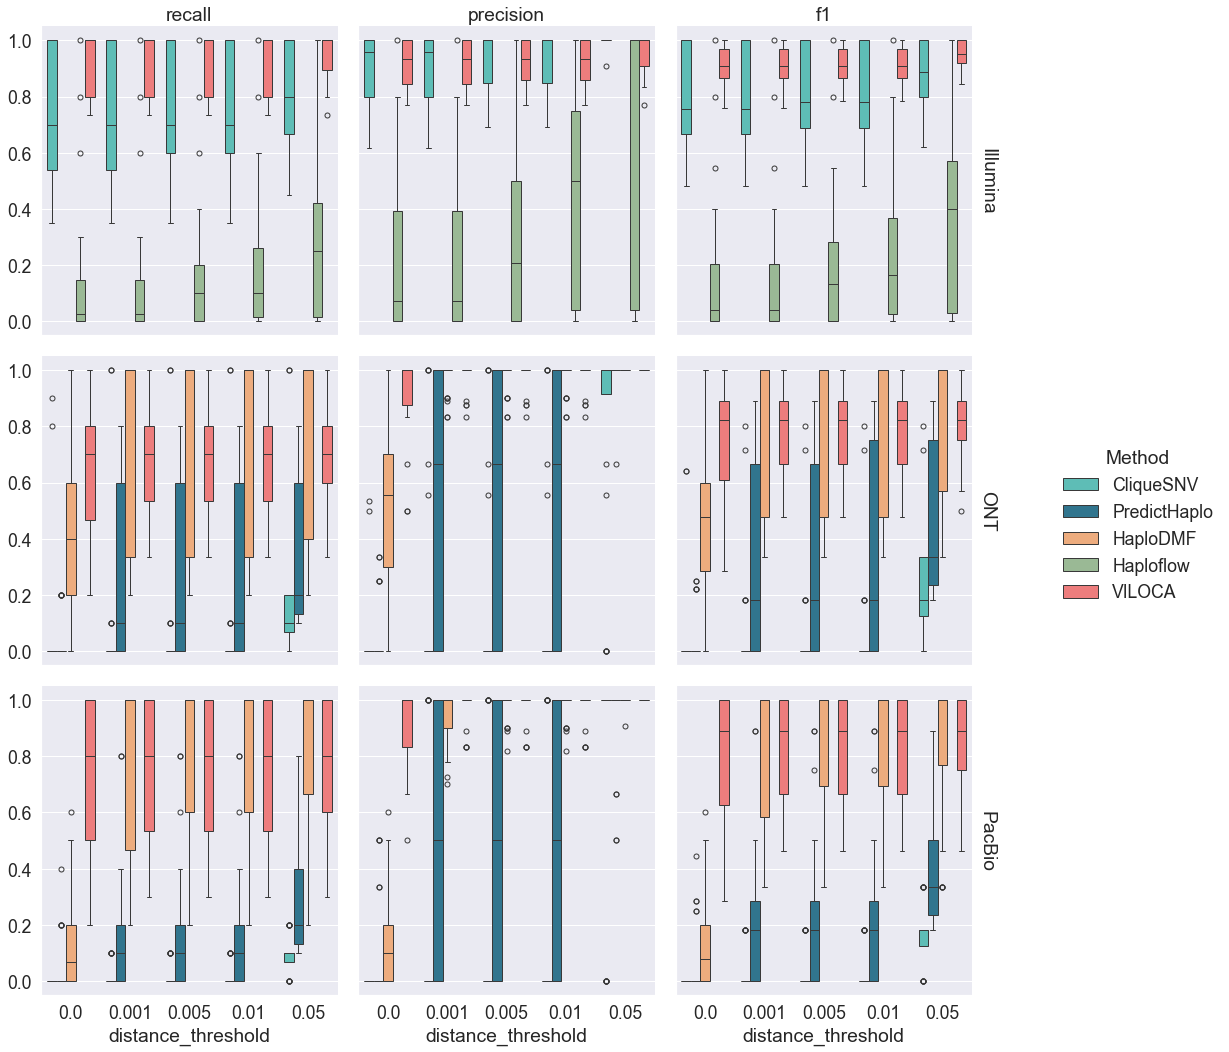

In [131]:
sns.set(font_scale=1.6)

g = sns.catplot(
        data=df_pr_long,
        col="variable",
        x="distance_threshold", 
        row='seq_tech', 
        y="value",
        hue="Method",
        hue_order = ["CliqueSNV", "PredictHaplo","HaploDMF", "Haploflow", "VILOCA", ],
        kind="box",
        legend=True, 
        palette=method_palette,
        sharex=True,
        sharey=True,
        margin_titles=True,
    )
g.set_titles(col_template='{col_name}', row_template='{row_name}')

#g.set(ylim=(-0.1, 1.1))

#g.set(xlabel ="")
g.set(ylabel ="")

g.tight_layout()

In [132]:
g.savefig('distance__haplo_pr_distance_thres.svg')

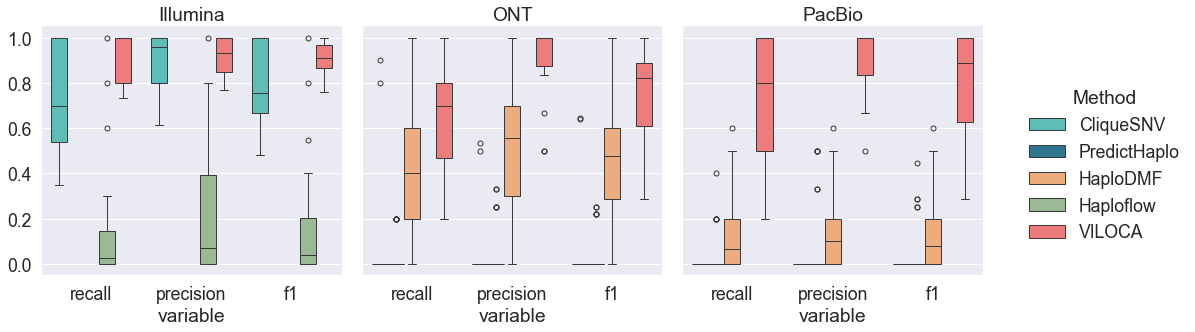

In [133]:
sns.set(font_scale=1.6)

g = sns.catplot(
        data=df_pr_long[df_pr_long['distance_threshold']==0],
        #col="variable",
        x="variable", 
        col='seq_tech', 
        y="value",
        hue="Method",
        hue_order = ["CliqueSNV", "PredictHaplo","HaploDMF", "Haploflow", "VILOCA", ],
        kind="box",
        legend=True, 
        palette=method_palette,
        sharex=True,
        sharey=True,
        margin_titles=True,
    )
g.set_titles(col_template='{col_name}', row_template='{row_name}')

#g.set(ylim=(-0.1, 1.1))

#g.set(xlabel ="")
g.set(ylabel ="")

g.savefig('distance__haplo_pr_distance_thres0.svg')

In [143]:
df_pr_long[(df_pr_long['distance_threshold']==0)
           &(df_pr_long['variable']=="precision")
           &(df_pr_long['Method']=="VILOCA")
          &(df_pr_long['seq_tech']!="Illumina")]['value'].mean()

0.9155555555555556

In [145]:
df_pr_long[(df_pr_long['distance_threshold']==0)
           &(df_pr_long['variable']=="recall")
           &(df_pr_long['Method']=="HaploDMF")
          &(df_pr_long['seq_tech']!="Illumina")]['value'].mean()

0.28800000000000003

In [141]:
df_pr_long[(df_pr_long['distance_threshold']==0)
           &(df_pr_long['variable']=="precision")
           &(df_pr_long['Method']=="CliqueSNV")
          &(df_pr_long['seq_tech']=="Illumina")]['value'].mean()

0.9027855477855478